# DTW: Part II

Only allowing 1-to-1 matches! CQT with onset annotations!!

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

from app.config import AppConfig

from app.modules.audio.AudioData import AudioData
from app.modules.audio.AudioPlayer import AudioPlayer
from app.modules.midi.MidiData import MidiData
from app.modules.midi.MidiPlayer import MidiPlayer
from app.modules.midi.MidiSynth import MidiSynth

from app.modules.pitch.PitchAnalyzer import PitchAnalyzer
from app.modules.dtw.MidiDTW import MidiDTW, CQTFeatures
from app.modules.dtw.PitchDTW import PitchDTW

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



### Step 0: Listen to the query (MIDI) vs. the template (ME)

Our goal is to warp the MIDI note lengths to match the user's recorded audio note lengths so we can easily compare pitches just by jumping to a point in the midifile.

In [3]:
# Create a synth with a soundfont
SOUNDFONT_FILEPATH = 'data/MuseScore_General.sf3'
midi_synth = MidiSynth(SOUNDFONT_FILEPATH)

# Load the midi file into a MidiData object
MIDI_FILEPATH = 'data/midi_files/fugue_midi.mid'
midi_data = MidiData(MIDI_FILEPATH)

# Create MidiSynth/Player objects
midi_player = MidiPlayer(midi_synth)
midi_player.load_midi(midi_data)

Loading MidiSynth...
Synth + soundfont loaded.


In [5]:
AUDIO_FILEPATH = 'data/audio_files/user_fugue2.mp3'

audio_data = AudioData()
audio_data.load_data('user_fugue2.mp3')
audio_player = AudioPlayer()
audio_player.load_audio_data(audio_data)

In [6]:
# Playback either the MIDI or user audio

# midi_player.play(start_time=0)
# audio_player.play(start_time=0)

## Step 1: Compute CQTs

CQT, or Constant-Q transform, represents the amount of energy in logarithmically spaced bins

Raffel, Ellis 2016 uses a constant-Q spectra spanning 4 octaves starting from MIDI note C2 (65.4 Hz) with 12 bins / octave. We also compute the log-amplitude and normalize the CQT for better results.

## Step 2: Compute onsets

MIDI onsets are determined by the file.

Within user audio, we detect two kinds of onsets
- `pitch_diff` - Using rolling median to detect when the pitch significantly changes
- `onset` - From essentia's 'complex' onset detection algorithm

Maybe instead of only getting the frame of CQT at the given onset, we get the mean/median of the nearest 10 frames? (Still a very small fraction of a second)

In [10]:
import numpy as np
import pandas as pd

MIDI_FILEPATH = 'data/midi_files/fugue_midi.mid'

midi_audio = AudioData()
midi_audio.load_midi_file('fugue.mid')
midi_data = MidiData(MIDI_FILEPATH)

midi_features = PitchDTW.midi_features(midi_data, midi_audio)

midi_features.onset_df

/Users/sarah/Desktop/shasha/MIDI-templater/notebooks/../app/modules/dtw/PitchDTW.py:86: ComplexWarning: Casting complex values to real discards the imaginary part
  cqt = cqt.astype(np.float32) # Store CQT as float32 to save space/memory


,time,cqt_norm
0,0.000000,"[-0.14525023, -0.18123695, -0.11763161, -0.101..."
1,0.187500,"[-0.14852832, -0.17480467, -0.22856793, -0.165..."
2,0.375001,"[-0.143507, -0.13530675, -0.13743159, -0.16570..."
3,0.562501,"[-0.15402356, -0.15334125, -0.14288092, -0.175..."
4,0.750002,"[-0.13072205, -0.13550499, -0.13812448, -0.149..."
...,...,...
60,11.250030,"[-0.16708627, -0.16488738, -0.18230057, -0.191..."
61,11.437530,"[-0.14122336, -0.20475908, -0.17110944, -0.152..."
62,11.625031,"[-0.16504312, -0.16297162, -0.15491305, -0.178..."
63,11.812532,"[-0.1611859, -0.14830263, -0.137423, -0.126110..."


In [12]:
user_features = PitchDTW.user_features(audio_data)
user_features.resegment_notes(15, .4)
user_features.onset_df

/Users/sarah/Desktop/shasha/MIDI-templater/notebooks/../app/modules/dtw/PitchDTW.py:86: ComplexWarning: Casting complex values to real discards the imaginary part
  cqt = cqt.astype(np.float32) # Store CQT as float32 to save space/memory


Computing pitches...
Done! Took 0.70 seconds.
Segmenting notes with window_size=11 and threshold=0.5...
Detecting onsets...
Onset detection complete.
Segmenting notes with window_size=15 and threshold=0.4...


,time,pitch_diff,onset,cqt_norm
0,0.000000,True,False,"[-0.14135821, -0.13323016, -0.13167313, -0.127..."
1,0.011610,False,True,"[-0.14135821, -0.13323016, -0.13167313, -0.127..."
2,0.232200,False,True,"[-0.17201978, -0.20225146, -0.17587388, -0.155..."
3,0.310567,True,False,"[-0.16594078, -0.18916063, -0.17836584, -0.159..."
4,0.464399,False,True,"[-0.1720972, -0.18694374, -0.1710854, -0.19140..."
...,...,...,...,...
139,12.695510,True,False,"[-0.15978037, -0.15970814, -0.1913471, -0.1776..."
140,12.759365,False,True,"[-0.16436683, -0.2036859, -0.21692996, -0.2131..."
141,12.910295,False,True,"[-0.20493986, -0.19791424, -0.1963422, -0.1954..."
142,12.974150,True,False,"[-0.15888634, -0.1916502, -0.18738528, -0.1643..."


## Step 3: Align the two sequences

In [13]:
alignment = PitchDTW.align(user_features, midi_features)

DTW alignment computed.
Distance: 6.142036419204395
Mean alignment error: 41.52777777777778


<Axes: xlabel='Query index', ylabel='Reference index'>

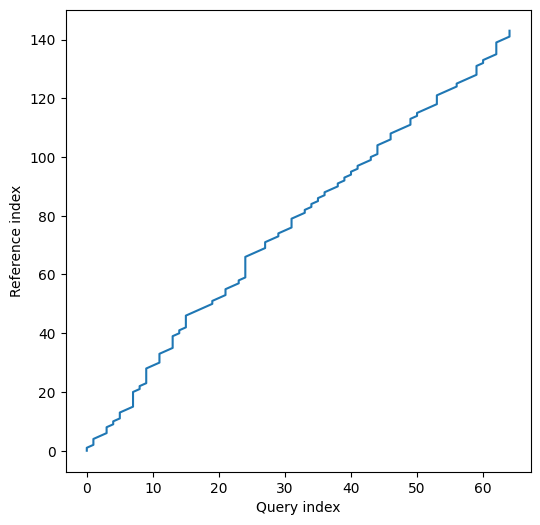

In [14]:
# Plot the alignment path
alignment.plot()

In [18]:
PitchDTW.export_midi(alignment, user_features, 
                     midi_features, midi_data)

Aligned MIDI written to aligned.mid


In [21]:
# Initialize a MidiSynth + MidiPlayer with a given soundfont
SOUNDFONT = 'data/MuseScore_General.sf3'
midi_synth = MidiSynth(soundfont_path=SOUNDFONT)
midi_player = MidiPlayer(midi_synth)

# Play a given midi file
MIDI_FILEPATH = 'aligned.mid'
midi_player.load_midi(MIDI_FILEPATH)
midi_player.play(start_time=0)

Loading MidiSynth...
Synth + soundfont loaded.


In [116]:
PitchDTW.print_aligned_times(alignment, user_features, midi_features)

Aligned times:
Note 0: User time = 0.00, MIDI time = 0.00
Note 1: User time = 0.01, MIDI time = 0.00
Note 2: User time = 0.02, MIDI time = 0.19
Note 3: User time = 0.23, MIDI time = 0.19
Note 4: User time = 0.42, MIDI time = 0.19
Note 5: User time = 0.44, MIDI time = 0.38
Note 6: User time = 0.46, MIDI time = 0.38
Note 7: User time = 0.51, MIDI time = 0.38
Note 8: User time = 0.64, MIDI time = 0.56
Note 9: User time = 0.66, MIDI time = 0.56
Note 10: User time = 0.74, MIDI time = 0.56
Note 11: User time = 0.79, MIDI time = 0.75
Note 12: User time = 0.85, MIDI time = 0.75
Note 13: User time = 0.89, MIDI time = 0.75
Note 14: User time = 0.92, MIDI time = 0.94
Note 15: User time = 1.09, MIDI time = 0.94
Note 16: User time = 1.11, MIDI time = 0.94
Note 17: User time = 1.15, MIDI time = 0.94
Note 18: User time = 1.18, MIDI time = 1.13
Note 19: User time = 1.27, MIDI time = 1.31
Note 20: User time = 1.30, MIDI time = 1.31
Note 21: User time = 1.36, MIDI time = 1.31
Note 22: User time = 1.49, 

In [120]:
aligned_user = user_features.onset_df.iloc[alignment.index2].reset_index(drop=True)
aligned_midi = midi_features.onset_df.iloc[alignment.index1].reset_index(drop=True)

flat_align_df = pd.DataFrame({
    'midi_time': aligned_midi['time'],
    'user_time': aligned_user['time']
})

# Group user_times by midi_time
grouped = flat_align_df.groupby('midi_time')['user_time'].apply(list).reset_index()

# Create a new DataFrame with distinct MIDI times and corresponding user times
align_df = pd.DataFrame({
    'midi_time': grouped['midi_time'],
    'user_times': grouped['user_time'].apply(lambda x: x if len(x) > 0 else [None])
})

align_df

,midi_time,user_times
0,0.000000,"[0.0, 0.01160997711122036]"
1,0.187500,"[0.023217481467087304, 0.2321995496749878, 0.4..."
2,0.375001,"[0.435327777507887, 0.4614474441583602, 0.5136..."
3,0.562501,"[0.635578555161515, 0.6617687344551086, 0.7400..."
4,0.750002,"[0.7864921846975824, 0.8532424439154584, 0.893..."
...,...,...
60,11.250030,"[12.017948844401065, 12.155646324157715]"
61,11.437530,[12.189177770220835]
62,11.625031,"[12.411066055297852, 12.508418140393285, 12.58..."
63,11.812532,"[13.260084102890238, 13.326834362108112]"


In [17]:
align_df2 = PitchDTW.align_df(alignment, user_features, midi_features)
align_df2

,midi_time,user_times,user_midi_pitches
0,0.000000,"[0.0, 0.01160997711122036]","[63.58919086616471, 62.01975157574046]"
1,0.187500,"[0.2321995496749878, 0.31056689342403626, 0.46...","[62.13555361614509, 62.13555361614509, 61.1202..."
2,0.375001,[0.5137414965986394],[61.01098039827877]
3,0.562501,"[0.6617687344551086, 0.6791836734693878, 0.716...","[72.90243872304268, 72.90243872304268, 75.7160..."
4,0.750002,"[0.8794557823129252, 0.8939682245254517]","[76.49716210534957, 76.76557586169102]"
...,...,...,...
60,11.250030,"[12.144036281179138, 12.155646324157715]","[65.17616444574598, 63.33828298900894]"
61,11.437530,[12.373333333333333],[62.36950772365466]
62,11.625031,"[12.411066055297852, 12.58521556854248, 12.605...","[74.25213547414363, 74.01975157574046, 74.0197..."
63,11.812532,[12.75936508178711],[72.0577667883459]
